In [8]:
import pandas as pd
import sys
import argparse
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np
import glob
import traceback
import re
from pathlib import Path

In [11]:
all_events_path = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251202_SNFH06_Session1\SNHF06_Session1_events.csv"
events_df = pd.read_csv(all_events_path)

def trial_timestamps(df, trial_col="trial", event_col="event", time_col="ros_time"):
    out = []

    for trial, g in df.groupby(trial_col, sort=False):
        g = g.sort_values(time_col)

        share_times = g.loc[g[event_col] == "share_button", time_col]
        rec_times   = g.loc[g[event_col] == "start_recording", time_col]
        sq_times    = g.loc[g[event_col] == "square_button", time_col]

        # start: prefer share_button, else start_recording
        if len(share_times) > 0:
            start_time = share_times.iloc[0]
        elif len(rec_times) > 0:
            start_time = rec_times.iloc[0]
        else:
            start_time = pd.NA

        # end: take the LAST square_button after start_time (fallback: last square_button)
        if len(sq_times) == 0:
            end_time = pd.NA
        else:
            if pd.isna(start_time):
                end_time = sq_times.iloc[-1]
            else:
                after = sq_times[sq_times >= start_time]
                end_time = after.iloc[-1] if len(after) > 0 else sq_times.iloc[-1]

        out.append({trial_col: trial, "start_time": start_time, "end_time": end_time})

    return pd.DataFrame(out)

# Example usage (edit trial_col if yours is "trial_number" etc.)
ts = trial_timestamps(events_df, trial_col="trial")
print(ts.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

# If you want to append these times onto every row in events_df:
events_df_with_times = events_df.merge(ts, on="trial", how="left")


 trial        start_time          end_time
     0 1764694205.994672 1764694460.634227
     1 1764694490.434961 1764694627.881043
     2 1764694765.979226 1764695012.803000
     3 1764695036.439461 1764695226.870298
     4 1764695253.090887              <NA>
     5 1764695368.565682 1764695571.898882
     6 1764695599.007145 1764695856.291564
     7 1764695890.860445 1764696035.780971
     8 1764696067.981101              <NA>
     9 1764696149.357975 1764696331.611730
    10 1764696354.063863 1764696488.717341
    11 1764696511.521420 1764696627.471050
    12 1764696646.382939 1764696773.932379
    13 1764696794.245437 1764696908.762048
    14 1764696929.466698 1764697014.395440
    15 1764697037.760031 1764697152.169045
    16 1764697178.837310 1764697305.427010
    17 1764697335.399118 1764697437.188038
    18 1764697458.408064 1764697565.896848
    19 1764697585.288554 1764697683.297583
    20 1764697708.657534 1764697837.322418
    21 1764697859.846613 1764697945.431386
    22 1764

In [12]:
ROOT = Path(r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251202_SNFH06_Session1\Rosbag")
TF_PARENT = ROOT / "SNHF06_Session1_000_tf"  # just to get the naming pattern
TF_GLOB = "SNHF06_Session1_*_tf"             # matches 000_tf, 001_tf, ...

TOPIC_SUBSTRINGS = [
    "vx300s-commands-joy_processed",
    "vx300s-gripper_pos",
    "vx300s-geppier_vel",   # your spelling
    "vx300s-gripper_vel",   # common spelling (in case)
]

TRIAL_IS_ONE_BASED = True

def pick_time_col(df: pd.DataFrame):
    """Try common time columns from bag conversions."""
    candidates = [
        "Time"
    ]
    for c in candidates:
        if c in df.columns:
            return c
    # last resort: any column containing 'time' or 'stamp'
    for c in df.columns:
        lc = c.lower()
        if "time" in lc or "stamp" in lc:
            return c
    raise ValueError(f"No time column found. Columns={list(df.columns)[:30]}...")

def find_topic_csvs(trial_folder: Path):
    """Return {substring: [csv_paths...]} for the substrings we care about."""
    csvs = list(trial_folder.glob("*.csv"))
    hits = {}
    for sub in TOPIC_SUBSTRINGS:
        matches = [p for p in csvs if sub in p.name]
        if matches:
            hits[sub] = matches
    return hits


def folder_index_from_name(folder: Path):
    # expects ..._000_tf
    m = re.search(r"_(\d{3})_tf$", folder.name)
    if not m:
        return None
    return int(m.group(1))

def segment_csv(in_path: Path, out_path: Path, start_time, end_time):
    df = pd.read_csv(in_path)
    tcol = pick_time_col(df)

    # Ensure numeric
    df[tcol] = pd.to_numeric(df[tcol], errors="coerce")

    seg = df[(df[tcol] >= start_time) & (df[tcol] <= end_time)].copy()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    seg.to_csv(out_path, index=False)
    return len(seg), tcol


def segment_all_trials (ts: pd.DataFrame, root: Path): 
    trial_folders = sorted(root.glob(TF_GLOB))
    for folder in trial_folders:
        idx = folder_index_from_name(folder)
        if idx is None:
            print(f"Skipping folder with unexpected name: {folder}")
            continue
        trial_num = idx  if TRIAL_IS_ONE_BASED else idx
        row = ts.loc[ts['trial'] == trial_num]
        if row.empty: 
            print(f"No timestamp data for trial {trial_num}, skipping folder {folder}")
            continue
        start_time = row['start_time'].values[0]
        end_time = row['end_time'].values[0]    
        
        if pd.isna(start_time) or pd.isna(end_time):
            print(f"[WARN] Missing start/end for trial={trial_num} -> start={start_time}, end={end_time}")
            continue
        hits = find_topic_csvs(folder)
        if not hits:
            print(f"[WARN] No matching topic CSVs found in {folder.name}")
            continue

        out_dir = folder / "segmented"
        print(f"\nTrial {trial_num} ({folder.name}) start={start_time} end={end_time}")

        for sub, paths in hits.items():
            for p in paths:
                out_path = out_dir / p.name.replace(".csv", "_seg.csv")
                n, tcol = segment_csv(p, out_path, start_time, end_time)
                print(f"  - {p.name}  -> {out_path.name}  rows={n}  (time_col={tcol})")
segment_all_trials(ts, ROOT)


Trial 0 (SNHF06_Session1_000_tf) start=1764694205.9946718 end=1764694460.6342273
  - vx300s-commands-joy_processed.csv  -> vx300s-commands-joy_processed_seg.csv  rows=25043  (time_col=Time)
  - vx300s-gripper_pos.csv  -> vx300s-gripper_pos_seg.csv  rows=2547  (time_col=Time)
  - vx300s-gripper_vel.csv  -> vx300s-gripper_vel_seg.csv  rows=2547  (time_col=Time)

Trial 1 (SNHF06_Session1_001_tf) start=1764694490.4349606 end=1764694627.8810432
  - vx300s-commands-joy_processed.csv  -> vx300s-commands-joy_processed_seg.csv  rows=12447  (time_col=Time)
  - vx300s-gripper_pos.csv  -> vx300s-gripper_pos_seg.csv  rows=1374  (time_col=Time)
  - vx300s-gripper_vel.csv  -> vx300s-gripper_vel_seg.csv  rows=1374  (time_col=Time)

Trial 2 (SNHF06_Session1_002_tf) start=1764694765.9792264 end=1764695012.803
  - vx300s-commands-joy_processed.csv  -> vx300s-commands-joy_processed_seg.csv  rows=22363  (time_col=Time)
  - vx300s-gripper_pos.csv  -> vx300s-gripper_pos_seg.csv  rows=2468  (time_col=Time)
 

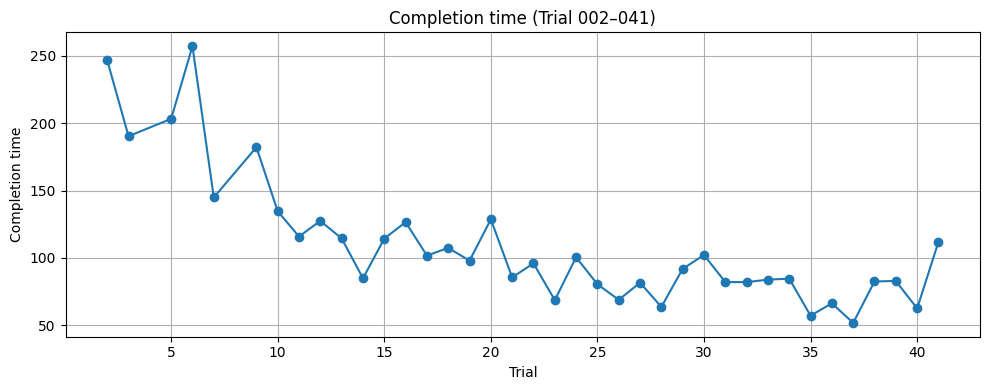

In [13]:
ts["trial"] = pd.to_numeric(ts["trial"], errors="coerce")
ts["start_time"] = pd.to_numeric(ts["start_time"], errors="coerce")
ts["end_time"]   = pd.to_numeric(ts["end_time"], errors="coerce")

# 2) compute completion time (seconds, if your ros_time is in seconds)
ts["completion_time"] = ts["end_time"] - ts["start_time"]

# 3) filter trials 002~041  -> 2~41
ts_2_41 = ts[(ts["trial"] >= 2) & (ts["trial"] <= 41)].copy()
ts_2_41 = ts_2_41.dropna(subset=["completion_time"]).sort_values("trial")

# optional: save
ts_2_41.to_csv("completion_time_trial002_041.csv", index=False)

# 4) plot
plt.figure(figsize=(10,4))
plt.plot(ts_2_41["trial"], ts_2_41["completion_time"], marker="o")
plt.xlabel("Trial")
plt.ylabel("Completion time")
plt.title("Completion time (Trial 002–041)")
plt.grid(True)
plt.tight_layout()
plt.show()
